In [1]:
import pandas as pd

import demoji
#from nltk.stem import WordNetLemmatizer
#from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
import re

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/andrey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/andrey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
####
# Preprocessing the Data: 
####

# Defining the Part-of-Speech mapping
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tag_map['AS'] = wn.ADJ_SAT

# To check if words are in English or not
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

isEnglish("hey")
isEnglish("здрасьте")


## Loading the data

# filepath = "finalized_8K_accounts.csv"
filepath = "finalized_8K_accounts_emojis_replaced.csv"
hand_label = "hand.label"
government = "gov"
academia = "acad"

df = pd.read_csv(filepath)

df = df[((df[hand_label]=='media') | (df[hand_label]== academia) | (df[hand_label]==government) | (df[hand_label]=='other' ))]


df = df[['username','description',hand_label]] # keep only relevant columns


# UPDATED (ANDREY'S): Doing the preprocessing/lemmatization, while 
#    1) accounting for Part-of-Speech; 
#    2) removing pure number entries;
#    3) [PROBABLY WON'T DO IT...] removing terms that contain non-English alphabet characters

lemmatizer = WordNetLemmatizer()

words_not_changed = ['media']

def preprocessing(row):
    if str(row) == "nan":
        lemma = ""
    else:
        row = str(row).lower()          # lowercase (so that upper and lowercase words are treated the same)
        row = word_tokenize(row)        # tokenize 
        lemma = [lemmatizer.lemmatize(token, tag_map[tag[0]]) if token not in words_not_changed else token for token, tag in pos_tag(row)] # lemmatization, depending on part-of-speech
        lemma = ["" if re.search(r'\b[0-9]+\b\s*', lem) else lem for lem in lemma]  # removing terms that only contain numbers
        # for lem in lemma: 
        #    if not isEnglish(lem): print(lem)
        # lemma = [lem if isEnglish(lem) else "" for lem in lemma]  # removing terms that contain non-English alphabet symbols
    return str(lemma)                     # convert back to string


# OLDER VERSION (MELVIN): Doing the preprocessing/lemmatization,
# words_not_changed = ['media']

#def preprocessing(row):
#    if str(row) == "nan":
#        row = ""
#    else:
#        row = str(row).lower()          # lowercase (so that upper and lowercase words are treated the same)
#        row = word_tokenize(row)        # tokenize  (to perform lemmitization)
#        row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize
#    return str(row)                     # convert back to string


df['description_lemmatized'] = df['description'].apply(preprocessing)


print(df.head())
print()

print(df.head())
print()
print('Number of labels per category:')
print(df[hand_label].value_counts())
print()

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  Former EPA Regional Administrator, President o...       acad   
2  nuclearkelly  Scientist at ORNL, DOE Early Career Awardee, F...       acad   
3       stukhan  Dad. Director of the Australian Graduate Schoo...       acad   
4       PatMag7  Podcasting about Feminist Participatory Action...       acad   

                              description_lemmatized  
0  ['army', 'civil', 'service', '(', 'retire', ')...  
1  ['former', 'epa', 'regional', 'administrator',...  
2  ['scientist', 'at', 'ornl', ',', 'doe', 'early...  
3  ['dad', '.', 'director', 'of', 'the', 'austral...  
4  ['podcast', 'about', 'feminist', 'participator...  

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  For

In [3]:
#print("SHAPE:", X.shape)
#display(X.to_string())
X = df['description_lemmatized']
count_vectorizer = CountVectorizer(stop_words="english")
X_trans = count_vectorizer.fit_transform(X)
print(X_trans.shape)
count_vectorizer.vocabulary_.keys()

(7852, 16408)


dict_keys(['army', 'civil', 'service', 'retire', 'military', 'ops', 'research', 'analyst', 'hl', 'fema', 'cert', 'criminal', 'justice', 'aeronautical', 'science', 'mba', 'faa', 'flight', 'instructor', 'epa', 'regional', 'administrator', 'president', 'plastic', 'bennington', 'college', 'visiting', 'professor', 'wamc', 'roundtable', 'friday', 'scientist', 'ornl', 'doe', 'early', 'career', 'awardee', 'frib', 'user', 'organization', 'chair', 'blind', 'view', 'dad', 'director', 'australian', 'graduate', 'school', 'engineering', 'agse', 'unsw', 'environmental', 'scientia', 'potentia', 'est', 'podcast', 'feminist', 'participatory', 'action', 'researcher', 'activist', 'mom', 'intersectional', 'feminism', 'gender', 'repurposed', 'emeritus', 'wnmu', 'grandmother', 'democrat', 'francophile', 'twittok', 'tiktok', 'come', 'party', 'balloon', 'incredible', 'amazing', 'videos', 'mobile', 'phone', 'tiktokcommunity', 'endless', 'entertainment', 'warning', 'weird', 'video', 'neuroscientist', 'new', 'orl

In [4]:
# split my data into training, and test sets
X = df['description_lemmatized']
y_labels = df[hand_label]

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [9]:
## Etc etc...Bag of Words: data preparation
## (https://machinelearningmastery.com/data-preparation-without-data-leakage/)

# 1. Conversion into bag-of-words representation
#count_vectorizer = CountVectorizer(stop_words="english")
#X_train_bag = count_vectorizer.fit_transform(X_train)      # Learns the training set's vocabulary dictionary and transforms the data into bag-of-words representation
#X_test_bag = count_vectorizer.transform(X_test)            # Uses the training set's vocabulary dictionary to transform into bag-of-words representation

# 2. Scaling of the data (avoiding data leakage)
#scaler = StandardScaler(with_mean = False)
#X_train_bag_scaled = scaler.fit_transform(X_train_bag)    # Learns the training set's standard deviations (scaling parameters) and scales the training data
#X_test_bag_scaled = scaler.transform(X_test_bag)          # Uses the training set's standard deviations to scale the test data (prevents data leakage)


#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [14]:
tfidf_transformer = TfidfTransformer()
count_vectorizer = CountVectorizer(stop_words="english")


tfidf_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('transformer', tfidf_transformer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

tfidf_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02], # 
        'transformer__use_idf': [True], # 'transformer__use_idf': [True, False],
        'classifier__C': [1.0e-10, 0.5, 3.0, 10.0], #'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]

In [15]:
count_vectorizer = CountVectorizer(stop_words="english")

bag_of_words_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

bag_of_words_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02], #     
        'classifier__C': [1.0e-10, 0.5, 3.0, 10.0], #'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]


In [16]:
# Grid Search - TF-IDF
tfidf_grid_search = GridSearchCV(estimator=tfidf_pipeline, param_grid=tfidf_param_grid, cv=5, scoring='accuracy', verbose=10, error_score="raise")

tfidf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.024 total time=   4.7s
[CV 2/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 2/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.024 total time=   4.5s
[CV 3/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 3/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, tran

[CV 5/5; 5/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.005 total time=   4.5s
[CV 1/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.024 total time=   1.7s
[CV 2/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 2/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.024 total time=   1.8s
[CV 3/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__mi

[CV 5/5; 10/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.005 total time=   2.8s
[CV 1/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 11/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.024 total time=   2.7s
[CV 2/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 2/5; 11/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.024 total time=   2.9s
[CV 3/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorize

[CV 4/5; 15/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.005 total time=   2.0s
[CV 5/5; 15/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 15/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.005 total time=   2.0s
[CV 1/5; 16/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 16/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.024 total time=   1.9s
[CV 2/5; 16/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__

[CV 4/5; 20/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.738 total time=   2.1s
[CV 5/5; 20/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 20/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.739 total time=   2.0s
[CV 1/5; 21/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 21/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.920 total time=   4.8s
[CV 2/5; 21/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min

[CV 4/5; 25/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.928 total time=   5.3s
[CV 5/5; 25/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 5/5; 25/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.931 total time=   5.1s
[CV 1/5; 26/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 26/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.821 total time=   1.4s
[CV 2/5; 26/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 

[CV 4/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.662 total time=   1.5s
[CV 5/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 5/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.646 total time=   1.4s
[CV 1/5; 31/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 31/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.617 total time=   1.6s
[CV 2/5; 31/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True,

[CV 4/5; 35/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.244 total time=   7.4s
[CV 5/5; 35/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 35/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.690 total time=  13.3s
[CV 1/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.726 total time=   3.7s
[CV 2/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vect

[CV 4/5; 40/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.773 total time=   1.2s
[CV 5/5; 40/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 40/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.763 total time=   1.6s
[CV 1/5; 41/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 41/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.928 total time=   5.9s
[CV 2/5; 41/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[

[CV 4/5; 45/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.932 total time=   1.8s
[CV 5/5; 45/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 5/5; 45/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.939 total time=   2.1s
[CV 1/5; 46/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 46/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.552 total time=   1.3s
[CV 2/5; 46/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vect

[CV 4/5; 50/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.686 total time= 1.2min
[CV 5/5; 50/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 5/5; 50/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.699 total time= 1.6min
[CV 1/5; 51/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 51/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.696 total time=  48.7s
[CV 2/5; 51/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True,

[CV 4/5; 55/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.333 total time=   1.4s
[CV 5/5; 55/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 55/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.766 total time=   1.1s
[CV 1/5; 56/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 56/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.748 total time=   1.1s
[CV 2/5; 56/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer

[CV 4/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.782 total time=   1.5s
[CV 5/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.769 total time=   1.4s
[CV 1/5; 61/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 61/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.934 total time=   1.7s
[CV 2/5; 61/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorize

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('transformer', TfidfTransformer()),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 3.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'transformer__use_idf': [True],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=10)

In [17]:
# Bag Of Words
bag_of_words_grid_search = GridSearchCV(estimator=bag_of_words_pipeline, param_grid=bag_of_words_param_grid, cv=5, scoring='accuracy', verbose=10,error_score="raise" )

bag_of_words_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 1/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.024 total time=   4.8s
[CV 2/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 2/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.024 total time=   4.2s
[CV 3/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 3/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.005 total time=   4.3s
[CV 4/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classi

[CV 5/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.005 total time=   2.1s
[CV 1/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 1/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.024 total time=   1.8s
[CV 2/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 2/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.024 total time=   1.7s
[CV 3/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 3/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.005 total t

[CV 4/5; 12/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.005 total time=   2.4s
[CV 5/5; 12/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 5/5; 12/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.005 total time=   2.4s
[CV 1/5; 13/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0
[CV 1/5; 13/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0;, score=0.024 total time=   5.9s
[CV 2/5; 13/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0
[CV 2/5; 13/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0;, score=0.024 t

[CV 3/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.683 total time=   4.0s
[CV 4/5; 18/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01
[CV 4/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.702 total time=   3.4s
[CV 5/5; 18/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01
[CV 5/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.746 total time=   5.7s
[CV 1/5; 19/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.015
[CV 1/5; 19/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.015;, score=0.722 tota

[CV 2/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.782 total time=   1.4s
[CV 3/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 3/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.790 total time=   1.4s
[CV 4/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 4/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.824 total time=   1.4s
[CV 5/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 5/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.845 total time=   1.2s
[

[CV 2/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.623 total time=   1.7s
[CV 3/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 3/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.605 total time=   1.5s
[CV 4/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 4/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.646 total time=   1.5s
[CV 5/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 5/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.635

[CV 1/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.754 total time=   3.0s
[CV 2/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 2/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.737 total time=   2.4s
[CV 3/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 3/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.738 total time=   2.6s
[CV 4/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 4/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.760 total 

[CV 1/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.814 total time=   1.0s
[CV 2/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 2/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.792 total time=   1.1s
[CV 3/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 3/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.811 total time=   0.9s
[CV 4/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 4/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.827 total time=   1.0s
[CV 5/5;

[CV 5/5; 47/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.015;, score=0.623 total time=   1.2s
[CV 1/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 1/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.632 total time=   1.1s
[CV 2/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 2/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.644 total time=   1.1s
[CV 3/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 3/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.66

[CV 4/5; 53/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0;, score=0.921 total time=   1.8s
[CV 5/5; 53/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0
[CV 5/5; 53/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0;, score=0.920 total time=   2.1s
[CV 1/5; 54/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01
[CV 1/5; 54/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.783 total time=   0.9s
[CV 2/5; 54/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01
[CV 2/5; 54/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.761 total time=   1.

[CV 4/5; 59/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015;, score=0.341 total time=   1.3s
[CV 5/5; 59/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015
[CV 5/5; 59/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015;, score=0.782 total time=   1.3s
[CV 1/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 1/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.762 total time=   1.3s
[CV 2/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 2/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.747 total time=   1.4

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 3.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=10)

In [18]:
tfidf_best_hyperparameters = tfidf_grid_search.best_params_
print("Best TF-IDF SVM ACCURACY:", tfidf_grid_search.best_score_)
print("Best TF-IDF SVM Hyperparameters:", tfidf_best_hyperparameters)

print()

Best TF-IDF SVM ACCURACY: 0.9430024981124809
Best TF-IDF SVM Hyperparameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear', 'transformer__use_idf': True, 'vectorizer__min_df': 0.0}



In [19]:
bag_of_words_best_hyperparameters = bag_of_words_grid_search.best_params_
print("Best Bag of Words ACCURACY:", bag_of_words_grid_search.best_score_)
print("Best Bag of Words Hyperparameters:", bag_of_words_best_hyperparameters)

print()

Best Bag of Words ACCURACY: 0.9410917967661352
Best Bag of Words Hyperparameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'sigmoid', 'vectorizer__min_df': 0.0}



In [20]:
# print(tfidf_grid_search.cv_results_)

In [21]:
tfidf_best_SVM_model = tfidf_grid_search.best_estimator_

In [22]:
bag_of_words_best_SVM_model = bag_of_words_grid_search.best_estimator_

In [24]:
tfidf_pipeline.set_params(**tfidf_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='linear'))])

In [25]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='linear'))])

In [26]:
bag_of_words_pipeline.set_params(**bag_of_words_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='sigmoid'))])

In [27]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='linear'))])

In [28]:
bag_of_words_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='sigmoid'))])

In [29]:
# Cross validate
y_pred_tfidf = cross_val_predict(tfidf_best_SVM_model, X_train, y_train, cv=5)

In [30]:
y_pred_bag_of_words = cross_val_predict(bag_of_words_best_SVM_model, X_train, y_train, cv=5)


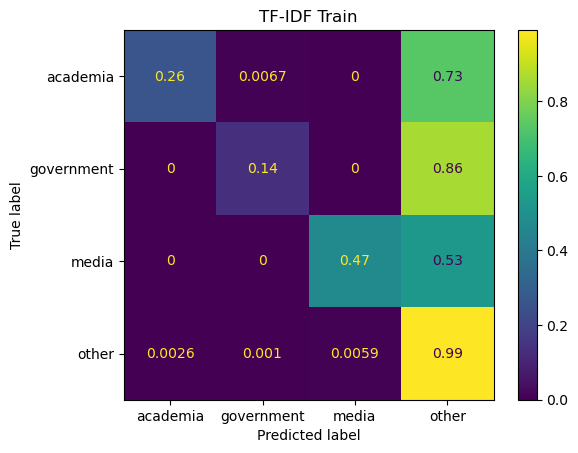

In [31]:
cm = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF Train")
plt.show()

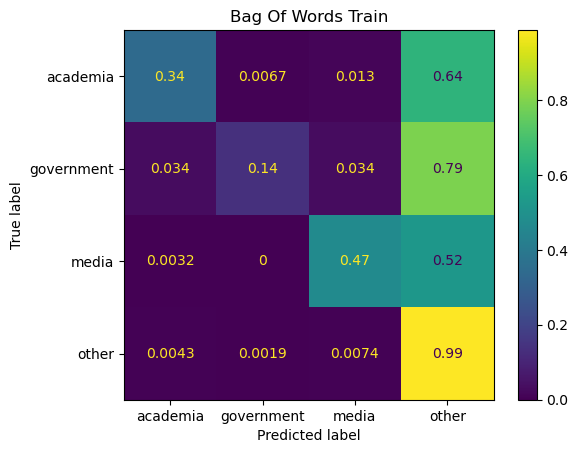

In [32]:
cm = confusion_matrix(y_train, y_pred_bag_of_words, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag Of Words Train")
plt.show()

In [33]:
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

TF-IDF Classification Report:
              precision    recall  f1-score   support

        acad       0.72      0.26      0.38       150
         gov       0.36      0.14      0.20        29
       media       0.82      0.47      0.60       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.71      0.47      0.54      6281
weighted avg       0.93      0.94      0.93      6281



In [34]:
print("Bag of Words Classification Report:")
print(metrics.classification_report(y_train, y_pred_bag_of_words))

Bag of Words Classification Report:
              precision    recall  f1-score   support

        acad       0.65      0.34      0.45       150
         gov       0.25      0.14      0.18        29
       media       0.77      0.47      0.58       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.66      0.48      0.54      6281
weighted avg       0.93      0.94      0.93      6281



In [39]:
tfidf_y_pred_test = tfidf_pipeline.predict(X_test)

#tfidf_pipeline.StandardScaler()

In [40]:
#StandardScaler(with_mean=False).fit(X_test)

# use fit() and transform separately
#std_slc = StandardScaler()
#X_train.CountVectorizer(stop_words="english")
#std_slc.fit(CountVectorizer(X_train, stop_words="english"))
#X_train_std = std_slc.transform(CountVectorizer(X_train, stop_words="english"))
#X_test_std = std_slc.transform(CountVectorizer(X_test, stop_words="english"))


#print('Transformed Train: \n', X_train_std[0:5])
#print('Transformed Test: \n', X_test_std[0:5])

In [41]:
bag_of_words_y_pred_test = bag_of_words_pipeline.predict(X_test)

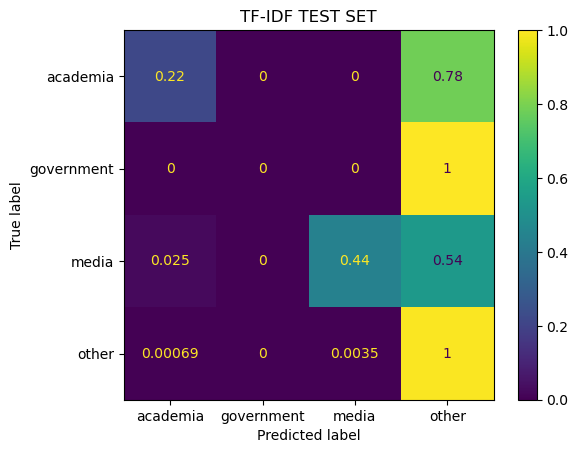

In [42]:
cm = confusion_matrix(y_test, tfidf_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF TEST SET")
plt.show()

In [45]:
tfidf_y_pred_test

array(['other', 'other', 'other', ..., 'other', 'other', 'other'],
      dtype=object)

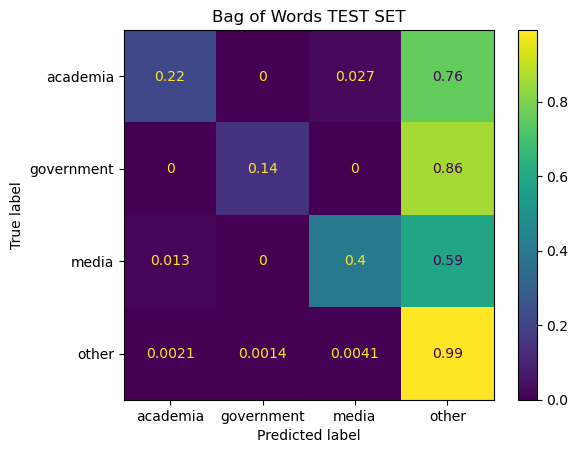

In [46]:
cm = confusion_matrix(y_test, bag_of_words_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag of Words TEST SET")
plt.show()

In [47]:
print("TF-IDF Classification Report TEST:")
print(metrics.classification_report(y_test, tfidf_y_pred_test))
print()

TF-IDF Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.73      0.22      0.33        37
         gov       0.00      0.00      0.00         7
       media       0.88      0.44      0.58        80
       other       0.95      1.00      0.97      1447

    accuracy                           0.94      1571
   macro avg       0.64      0.41      0.47      1571
weighted avg       0.93      0.94      0.93      1571




/home/andrey/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrey/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrey/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print("Bag of Words Classification Report TEST:")
print(metrics.classification_report(y_test, bag_of_words_y_pred_test))
print()

Bag of Words Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.67      0.22      0.33        37
         gov       0.33      0.14      0.20         7
       media       0.82      0.40      0.54        80
       other       0.95      0.99      0.97      1447

    accuracy                           0.94      1571
   macro avg       0.69      0.44      0.51      1571
weighted avg       0.93      0.94      0.93      1571


